In [1]:
import numpy as np
import pandas as pd
import glob
import os
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import matplotlib.pylab as plt
import glob
from scipy.ndimage.interpolation import rotate
# import scipy
import sugartensor as tf

import sys
sys.path.append('../')
import UtilsLJ
from tqdm import tqdm
import sys
#sys.path.append('./PointSetGeneration/depthestimate')

os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="5"

#About Data

batSize=100
maxStep=300000 # fixed with learningRate and learningRateDecay
learningRate=1e-3
learningRateDecay=0.995
lrType=1 #learning rate type
lr2Period=5
adam_beta2=0.99
conWeightVar=['NNReg','global_step'] # variables to be loaded
saveStep=10000 # frequency to save weight
maxKeepWeights=2000 # how many records to save (for disk)
stepsContinue=-1  # from which steps continu.
#For Debug and results printing
keepProb=0.99999
# Totally dosen't work if put dropout after max-pool layer. 
printStep=10
ss=2048
dat="Fish_Visual_Epoch"
FBN=0
NRT=1
# dirSave="../TFweights/Simple{}_NR_{}_FBN_{}_Ss_{}_Bs_{}_lrT_{}_LR_{}_LRdecay_{}_Dkp_{}".format(
#     dat, NRT, FBN, ss, batSize, lrType, learningRate, learningRateDecay,keepProb)

#conWeightPath="./TFweights/Simple2Dto3DMGPU_NR_1_FBN_0_Ss_1024_Bs_32_lrT_1_LR_0.001_LRdecay_0.999_Dkp_0.99999"
#conWeightPath="./TFweights/SimpleFishCorrProgress_NR_1_FBN_0_Ss_2048_Bs_16_lrT_1_LR_0.001_LRdecay_0.995_Dkp_0.99999"

#conWeightPath="./TFweights/SimpleFishEdge_NR_1_FBN_0_Ss_2048_Bs_16_lrT_1_LR_0.001_LRdecay_0.995_Dkp_0.99999"

# conWeightPath="../TFweights/SimpleFishCorrProgressResid_NR_1_FBN_0_Ss_2048_Bs_16_lrT_1_LR_0.001_LRdecay_0.995_Dkp_0.99999"




In [2]:
conWeightPath="./TFweights/SimpleFish_Train_Deform=0.4_NR_1_FBN_0_Ss_2048_Bs_16_lrT_1_LR_0.001_LRdecay_0.995_Dkp_0.99999/"

In [3]:
def NNReg(x, x1):
    with tf.sg_context(name='NNReg', stride=1, size=1,act='leaky_relu', bn=True, reuse=tf.AUTO_REUSE):
        
        
        x1=(tf.expand_dims(x1,2)).sg_conv(dim=64,name='l1')
        print(x1)
#         x2=x1.sg_conv(dim=64,name="l2")
        x3=x1.sg_conv(dim=64,name="l3")
        x4=x3.sg_conv(dim=128,name="l4")
        x5=x4.sg_conv(dim=512,name="l5")
        x5=tf.nn.max_pool(x5, ksize=[1, x1.shape[1], 1, 1], padding="VALID", strides=[1,1,1,1])
  
        print(x5)
        ffc1=tf.tile(x5,[1,x.shape[1],1,1])
        x=tf.expand_dims(x,2)
#         x=(xo).sg_conv(dim=16,name='ll1', size=1, stride=1)
#         x=x.sg_conv(dim=64,name="ll2",size=1, stride=1)

        xx=tf.concat([x, ffc1], axis=-1)

#         xx=xx.sg_conv(dim=256,name='ll3', size=1, stride=1)
#         xx=xx.sg_conv(dim=64,name="ll4",size=1, stride=1)
#         xx=xx.sg_conv(dim=3,name="ll5",size=1, stride=1)

#         xx=tf.concat([xx, ffc1], axis=-1)

        xx=xx.sg_conv(dim=256,name='ll6', size=1, stride=1)
        xx=xx.sg_conv(dim=64,name="ll7",size=1, stride=1)
        xx=xx.sg_conv(dim=2,name="ll8",size=1, stride=1, act="linear", bn=False)  
        
        xx=x+xx
        
        xx=tf.squeeze(xx,axis=2)
        
        
    return xx

In [4]:
def VisBat(x, yt,y_hat):
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(1, figsize=(15, 30))
    for j in range(6):
            d1=np.asarray((x[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(10, 10))
            ax = fig.add_subplot(6, 3, j*3+1)
            ax.scatter(d1[:, 0], d1[:, 1], c=range(len(d1)), s=20, cmap="plasma")
            
            for iii in range(0, len(d1),3):
                ax.text(d1[iii,0], d1[iii,1], str(iii))
            
            ax.axis('off')
        
            d=np.asarray((yt[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(5, 5))
            ax = fig.add_subplot(6, 3, j*3+2)
            ax.scatter(d[:, 0],d[:, 1],s=20)
            for iii in range(0, len(d),3):
                ax.text(d[iii,0], d[iii,1], str(iii))
            
            ax.axis('off')

            d=np.asarray((y_hat[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(5, 5))
            ax = fig.add_subplot(6, 3, j*3+3)                        
            ax.scatter(d[:, 0],d[:, 1],c=range(len(d1)), s=20, cmap="plasma")
            for iii in range(0, len(d1),3):
                ax.text(d[iii,0], d[iii,1], str(iii))
            ax.axis('off')

    plt.show() 

In [5]:
def chamfer_loss(A,B):    
    r=tf.reduce_sum(A*A,2)
    r=tf.reshape(r,[int(r.shape[0]),int(r.shape[1]),1])
    r2=tf.reduce_sum(B*B,2)
    r2=tf.reshape(r2,[int(r.shape[0]),int(r.shape[1]),1])
    t=(r-2*tf.matmul(A, tf.transpose(B,perm=[0, 2, 1])) + tf.transpose(r2,perm=[0, 2, 1]))
    return tf.reduce_mean(tf.reduce_min(t, axis=1)+tf.reduce_min(t,axis=2))

In [6]:
def test():
    tf.reset_default_graph()
    tf.set_random_seed(888)
    print("*****************************************")
    print("Training started with random seed: {}".format(RSW))
    print("Batch started with random seed: {}".format(RSD))

    
    x=UtilsLJ.read_from_tfrecords(
    ['./data/Fish_Test_Def=0.4.tfrecords'],['x'],batSize,
                                  [[91,2]])
    x=tf.constant(tf.sg_print(x))

    r=2
    record=np.asarray([(r*np.cos(i), r*np.sin(i)) for i in np.linspace(0,2*np.pi,91)])
    cord=tf.constant(record,dtype=tf.float32)
    xx=tf.tile(tf.expand_dims(cord,dim=0), [batSize,1,1])

    global_step = tf.Variable(1, trainable=False,name='global_step')
    y_hat=NNReg(xx,x)
    cl=chamfer_loss(y_hat, x)*3000
    Loss=cl
    saver = tf.train.Saver(max_to_keep=int(maxKeepWeights))
    init_op = tf.group(tf.global_variables_initializer(),
                               tf.local_variables_initializer())
    # Continue Training************************************************************************
    if len(conWeightPath)>0:
        print("Continue Training...")
        tmp_var_list={}
        if len(conWeightVar)==0:
            print("For all variables")
            globals()['conWeightVar']={''}
        else:
            print("Training variables: {}".format(conWeightVar))
            
        for j in conWeightVar: 
            for i in tf.global_variables():
                if i.name.startswith(j):
                    tmp_var_list[i.name[:-2]] = i
        saver1=tf.train.Saver(tmp_var_list) 
    # For Testing Dosent matther****************************************************************   
    
    # Training**********************************************************************************    
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        # Read Weight******************************
        if len(conWeightPath)>0:
            print(conWeightPath)
            if stepsContinue==-1:            
                STEPS=sorted([int(i.split("/")[-1].split(".")[1].split("-")[-1]) for i in glob.glob(conWeightPath+"/*meta")])
                globals()['stepsContinue']=STEPS[-1]
                
            wtt=glob.glob(conWeightPath+"/*-{}*meta".format(stepsContinue))[0][:-5]
            print("Reading Weight:{}".format(wtt))
            saver1.restore(sess,wtt)
            print('Weight is successfully updated from: {}'.format(wtt))  
        #*******************************************    
        stepst = sess.run(global_step)
        
            
        f0,f1, f2, loss=sess.run([xx, x, y_hat, Loss])
        VisBat(f0,f1,f2)
        print('loss:', loss)
     
        coord.request_stop()
        coord.join(threads)
        
        return f0,f1, f2, loss

*****************************************
Training started with random seed: 1
Batch started with random seed: 1
[[[-1.15656722 -0.32849938]
  [-1.1450634  -0.27120826]
  [-1.10942769 -0.26040974]
  ..., 
  [-1.24079239 -0.43356916]
  [-0.37489146 -0.80545968]
  [-0.21920596 -0.82301933]]

 [[-0.81595039  0.06480059]
  [-0.80212498  0.14719364]
  [-0.76969016  0.13778767]
  ..., 
  [-0.90999526 -0.1127272 ]
  [-0.03697963 -0.7706365 ]
  [ 0.09589496 -0.77030945]]

 [[-0.61904049  0.07459237]
  [-0.60120189  0.1407401 ]
  [-0.58866233  0.14778352]
  ..., 
  [-0.72334647 -0.07826911]
  [-0.3870585  -0.56434149]
  [-0.23433203 -0.58387429]]

 ..., 
 [[-0.63713288 -0.31040317]
  [-0.59664845 -0.25813484]
  [-0.55813205 -0.24800414]
  ..., 
  [-0.83415866 -0.40744555]
  [ 0.09123132 -0.81548238]
  [ 0.25106323 -0.82976395]]

 [[-0.95451993 -0.45333645]
  [-0.93489236 -0.40007758]
  [-0.89918923 -0.40105933]
  ..., 
  [-1.07531023 -0.54954565]
  [-0.11107301 -0.75476873]
  [ 0.05395492 -0.76

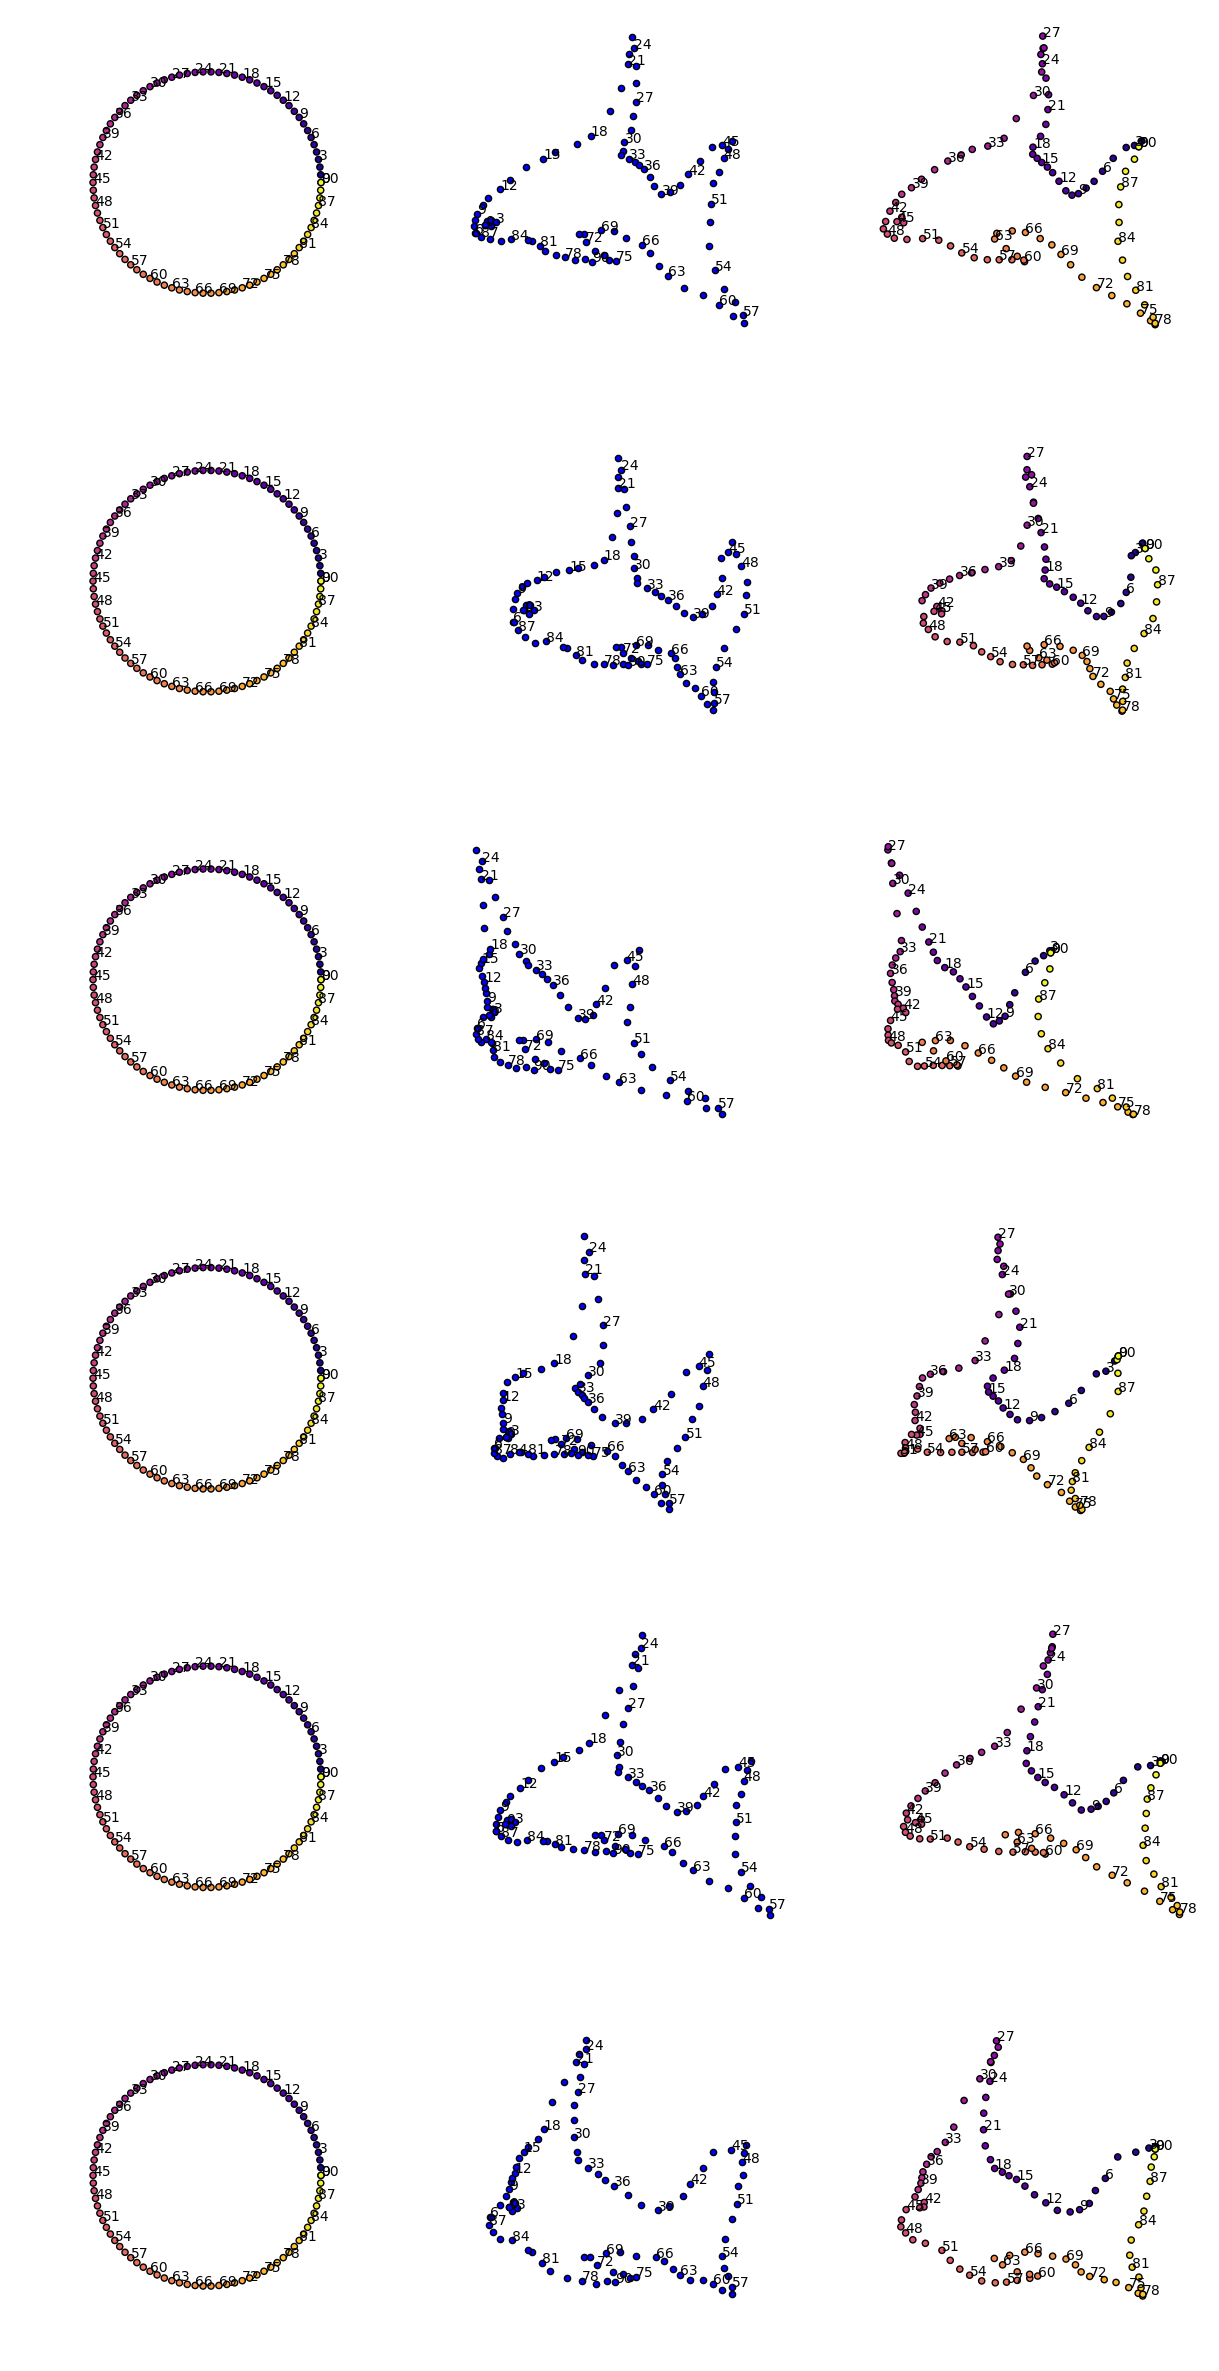

('loss:', 13.343703)


In [7]:
# for i in range(500,50000,500)[-1:]:
i=600000
stepsContinue=i
RSW=1
RSD=1
f0,f1, f2, loss = test()


In [8]:
f0.shape

(100, 91, 2)

In [19]:
print(f0.shape, f1.shape, f2.shape)
threshod = np.linspace(0, 1, 20)
thr_acc = []

for thr in threshod:

    correct_list = []
    avg_ind_loss = 0.0
    for i in range(len(f0)):
        for j in range(len(f0)):
            if j==i:
                continue
            pred1 = f2[i,:,:]
            pred2 = f2[j,:,:]
            gt1 = f1[i,:,:]
            gt2 = f1[j,:,:]
            correct = 0.0
            for ind in range(len(pred1)):
                pos1 = pred1[ind,:]
                pos2 = pred2[ind,:]
                find1 = np.argmin(np.sum((gt1-pos1)**2, axis=-1))#gt
                find2 = np.argmin(np.sum((gt2-pos2)**2, axis=-1))#pred
                avg_ind_loss += np.minimum(np.abs(find1-find2), len(pred1)-np.abs(find1-find2))

                cor1 = gt2[find1]  #gt
                cor2 = gt2[find2]  #pred
                dist = np.sqrt(np.sum((cor1-cor2)**2))
#                 print(ind, find1, find2, dist)
                if dist<=thr:
                    correct+=1
            acc = float(correct)/len(pred1)
            correct_list.append(acc)
#             find_err_list.append(float(find_err)/len(pred1))

    print('acc for threshold: %f, acc: %f' % (thr, np.mean(correct_list)))
    print('average find loss:', float(avg_ind_loss)/(len(f0)*(len(f0)-1)*len(pred1)))
    thr_acc.append(np.mean(correct_list))
print('acc list:', thr_acc)

((100, 91, 2), (100, 91, 2), (100, 91, 2))
acc for threshold: 0.000000, acc: 0.349835
('average find loss:', 1.5027461427461428)
acc for threshold: 0.052632, acc: 0.373508
('average find loss:', 1.5027461427461428)
acc for threshold: 0.105263, acc: 0.527394
('average find loss:', 1.5027461427461428)
acc for threshold: 0.157895, acc: 0.698106
('average find loss:', 1.5027461427461428)
acc for threshold: 0.210526, acc: 0.815710
('average find loss:', 1.5027461427461428)
acc for threshold: 0.263158, acc: 0.886442
('average find loss:', 1.5027461427461428)
acc for threshold: 0.315789, acc: 0.927869
('average find loss:', 1.5027461427461428)
acc for threshold: 0.368421, acc: 0.953504
('average find loss:', 1.5027461427461428)
acc for threshold: 0.421053, acc: 0.968858
('average find loss:', 1.5027461427461428)
acc for threshold: 0.473684, acc: 0.980624
('average find loss:', 1.5027461427461428)
acc for threshold: 0.526316, acc: 0.986754
('average find loss:', 1.5027461427461428)
acc for thr

In [8]:
#################
######绘制不同deformation level的图,V2########
#################

x = f0 # circle
yt = f1 # 输入点云
y_hat = f2 #reconstuction

j=55
d_gt=np.asarray((yt[j])).reshape(-1,2)
d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
rec_to_gt = np.zeros((91,))
gt_to_rec = np.zeros((91,))
for iii in range(91):
    dist1 = np.sum((d_hat[iii]-d_gt)**2,axis=-1)
    rec_to_gt[iii] = np.argmin(dist1)
    dist2 = np.sum((d_hat-d_gt[iii])**2,axis=-1)
    gt_to_rec[iii] = np.argmin(dist2)
print(gt_to_rec)
# print(set(gt_to_rec))



[ 48.  45.  45.  45.  49.  48.  49.  48.  46.  47.  42.  41.  40.  39.  37.
  36.  35.  33.  32.  22.  24.  25.  26.  27.  28.  25.  24.  23.  23.  31.
  20.  19.  18.  17.  15.  14.  13.  12.  10.   9.   8.   7.   5.   4.   3.
   2.   0.  88.  87.  85.  85.  83.  83.  82.  81.  80.  80.  79.  78.  76.
  75.  74.  73.  71.  71.  70.  69.  68.  67.  66.  65.  65.  64.  63.  62.
  61.  60.  58.  56.  56.  54.  53.  53.  52.  51.  51.  50.  49.  49.  57.
  59.]


In [27]:
#################
######计算当前def=0.3时的metrics,V2########
#################

print(f0.shape, f1.shape, f2.shape)
threshod = np.linspace(0, 1, 20)
thr_acc = []

for thr in threshod:

    correct_list = []
    avg_ind_loss = 0.0
    for i in range(len(f0))[:1]:
        for j in range(len(f0)):
            if j==i:
                continue
#             pred1 = f2[i,:,:]
            pred2 = f2[j,:,:]
#             gt1 = f1[i,:,:]
            gt2 = f1[j,:,:]
            correct = 0.0
            for iii in range(len(gt2)):
                
                ind = gt_to_rec[iii]
                dist = np.sum((pred2[ind]-gt2)**2,axis=-1)
                ind_min = np.argmin(dist)
                
                cor1 = gt2[iii]  #gt
                cor2 = gt2[ind_min]  #pred
                dist = np.sqrt(np.sum((cor1-cor2)**2))

                if dist<=thr:
                    correct+=1
            
            acc = float(correct)/len(pred2)
            correct_list.append(acc)
#             find_err_list.append(float(find_err)/len(pred1))

    print('acc for threshold: %f, acc: %f' % (thr, np.mean(correct_list)))
    print('average find loss:', float(avg_ind_loss)/(1*(len(f0)-1)*len(pred2)))
    thr_acc.append(np.mean(correct_list))
print('acc list:', thr_acc)

((100, 91, 2), (100, 91, 2), (100, 91, 2))


/home/mmvc/anaconda2/envs/Xiang_Li/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


acc for threshold: 0.000000, acc: 0.284271
('average find loss:', 0.0)
acc for threshold: 0.052632, acc: 0.305250
('average find loss:', 0.0)
acc for threshold: 0.105263, acc: 0.462648
('average find loss:', 0.0)
acc for threshold: 0.157895, acc: 0.647575
('average find loss:', 0.0)
acc for threshold: 0.210526, acc: 0.768676
('average find loss:', 0.0)
acc for threshold: 0.263158, acc: 0.846598
('average find loss:', 0.0)
acc for threshold: 0.315789, acc: 0.899434
('average find loss:', 0.0)
acc for threshold: 0.368421, acc: 0.930958
('average find loss:', 0.0)
acc for threshold: 0.421053, acc: 0.951715
('average find loss:', 0.0)
acc for threshold: 0.473684, acc: 0.969586
('average find loss:', 0.0)
acc for threshold: 0.526316, acc: 0.978910
('average find loss:', 0.0)
acc for threshold: 0.578947, acc: 0.984238
('average find loss:', 0.0)
acc for threshold: 0.631579, acc: 0.988123
('average find loss:', 0.0)
acc for threshold: 0.684211, acc: 0.991342
('average find loss:', 0.0)
acc fo

In [29]:
ind_loss = float(avg_ind_loss)/(1*(len(f0)-1)*len(pred2))
np.save('Results/train_deformation_new/thr_acc_train_def=0.4_new_V1.npy', (threshod, thr_acc, ind_loss))

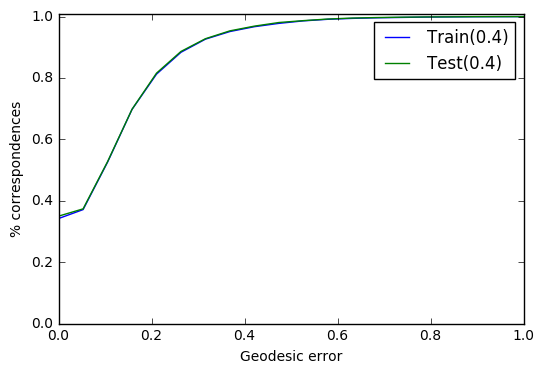

In [22]:
#################
######train/test evaluation metrics########
#################

# threshod_tr3, thr_acc_tr3,_ = np.load('Results/train_deformation/thr_acc_train_def=0.3.npy')
# threshod_t3, thr_acc_t3,_ = np.load('Results/test_deformation/thr_acc_test_def=0.3.npy')
threshod_tr4, thr_acc_tr4,_ = np.load('Results/train_deformation/thr_acc_train_def=0.4V2.npy')
threshod_t4, thr_acc_t4,_ = np.load('Results/test_deformation/thr_acc_test_def=0.4V2.npy')

plt.figure()
# plt.plot(threshod_tr3, thr_acc_tr3)
# plt.plot(threshod_t3, thr_acc_t3)

plt.plot(threshod_tr4, thr_acc_tr4)
plt.plot(threshod_t4, thr_acc_t4)

plt.xlabel('Geodesic error')
plt.ylabel('% correspondences')
plt.legend(['Train(0.4)', 'Test(0.4)'])
plt.xlim([0,1])
plt.ylim([0,1.01])
# plt.savefig('fig_def_train_test.png',dpi=300)
plt.show()


In [1]:
#################
######绘制不同deformation level的图 V2########
#################

x = f0 # circle
yt = f1 # 输入点云
y_hat = f2 #reconstuction
plt.clf()

# chocie_list = [55,56,57,58, 59,60,61, 62]
chocie_list = [55,59,62]

j=55
#######参考gt
fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
ax = fig.add_subplot(111)
d_gt=np.asarray((yt[j])).reshape(-1,2)
for iii in range(91):
    if iii==18:
        ax.scatter(d_gt[18, 0], d_gt[18, 1], s=55, linewidths=0, c='r', marker='^')
    else:
        ax.scatter(d_gt[iii, 0], d_gt[iii, 1], s=15, linewidths=0, cmap="plasma", marker='o')  


for iii in [0,18,23,32,39,46,52,58,71,76,82,88]: #range(1,91,3):
    ax.text(d_gt[iii,0], d_gt[iii,1], str(iii))

ax.axis('off')

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0.1,0.1)
# fig.savefig('Results/deformation_examples4/base_def4_gt_%d.png' % (j), format='png', transparent=True, dpi=300, pad_inches = 0)
plt.show()


# fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
# ax = fig.add_subplot(111)
d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
# ax.scatter(d_hat[:, 0],d_hat[:, 1], s=15, linewidths=0)
rec_to_gt = np.zeros((91,))
gt_to_rec = np.zeros((91,))
for iii in range(91):
    dist1 = np.sum((d_hat[iii]-d_gt)**2,axis=-1)
    rec_to_gt[iii] = np.argmin(dist1)
    dist2 = np.sum((d_hat-d_gt[iii])**2,axis=-1)
    gt_to_rec[iii] = np.argmin(dist2)
# print(gt_to_rec)
# print(set(gt_to_rec))

plt.clf()
for row in range(3):
    
    j = chocie_list[row]
    print('fish: %d' % (j))
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)  
    ax = fig.add_subplot(111)   

    #######参考gt
    d_gt=np.asarray((yt[j])).reshape(-1,2)
    for iii in range(91):
        if iii==18:
            ax.scatter(d_gt[18, 0], d_gt[18, 1], s=55, linewidths=0, c='r', marker='^')
        else:
            ax.scatter(d_gt[iii, 0], d_gt[iii, 1], s=15, linewidths=0, c='b', marker='o')
    
    
    for iii in [0,23,32,39,46,52,58,71,76,82,88]: #range(1,91,3):
        ax.text(d_gt[iii,0], d_gt[iii,1], str(iii))
    ax.text(d_gt[18,0], d_gt[18,1], str(18))
#     ax.scatter(d_gt[18,0], d_gt[18,1], c='r', s=25, linewidths=0, marker='^')
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)
#     fig.savefig('Results/deformation_examples4/fig_fish_def4_gt_%d.png' % (j), format='png', transparent=True, dpi=300, pad_inches = 0)
    plt.show()
    
    #######prediction correspondence
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
    ax = fig.add_subplot(111)
    d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
    for iii in range(91):
        if iii==18:
            ax.scatter(d_gt[18, 0], d_gt[18, 1], s=55, linewidths=0, c='r', marker='^')
        else:
            ax.scatter(d_gt[iii, 0], d_gt[iii, 1], s=15, linewidths=0, cmap="plasma", marker='o')    
    
    for iii in [0,18,23,32,39,46,52,58,71,76,82,88]: #range(1,91,3):
        rec_ind = gt_to_rec[iii]
        dist = np.sum((d_hat[rec_ind]-d_gt)**2,axis=-1)
        ind = np.argmin(dist)
        ax.text(d_gt[ind,0], d_gt[ind,1], str(ind),fontsize=10)
        if iii==18:
            print('point correspoond to 18, rec_ind:%d, gt2 ind: %d' % (rec_ind, ind))
            ax.scatter(d_gt[ind, 0], d_gt[ind, 1], s=95, linewidths=2, c='g', marker='+')
    ax.axis('off')
    
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)

#     fig.savefig('Results/deformation_examples4/fig_fish_def4_pred_%d.png' % (j),\
#                 format='png', transparent=True, dpi=300, pad_inches = 0)

    plt.show()

    
    #######reconstruction
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
    ax = fig.add_subplot(111)
    d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
    ax.scatter(d_hat[:, 0],d_hat[:, 1],c=range(len(d_hat)), s=15, linewidths=0, cmap="plasma")
    for iii in range(1, len(d_hat),5):
        ax.text(d_hat[iii,0], d_hat[iii,1], str(iii),fontsize=10)
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)
    
#     fig.savefig('Results/deformation_examples4/fig_fish_def4_rec_%d.png' % (j),\
#                 format='png', transparent=True, dpi=300, pad_inches = 0)
    
    plt.show()


NameError: name 'f0' is not defined

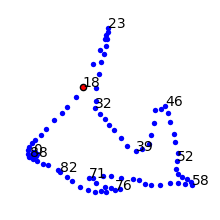

fish: 55


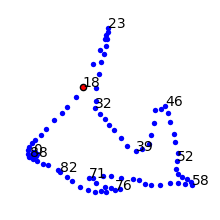

/home/mmvc/anaconda2/envs/Xiang_Li/lib/python2.7/site-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


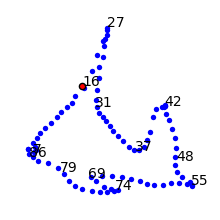

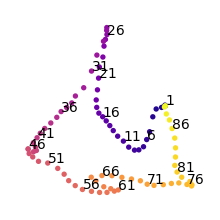

fish: 59


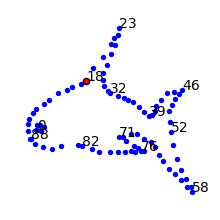

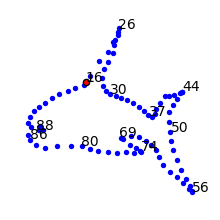

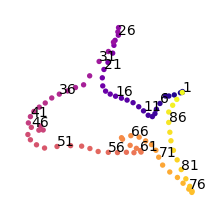

fish: 62


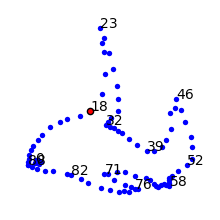

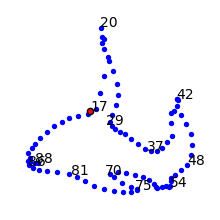

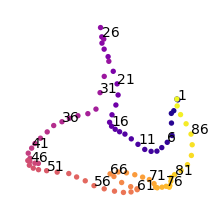

In [11]:
#################
######绘制不同deformation level的图########
#################

x = f0 # circle
yt = f1 # 输入点云
y_hat = f2 #reconstuction
plt.clf()

chocie_list = [55,56,57,58, 59,60,61, 62]
chocie_list = [55,59,62]

j=55
#######参考gt
fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
ax = fig.add_subplot(111)
d_gt=np.asarray((yt[j])).reshape(-1,2)
ax.scatter(d_gt[:, 0], d_gt[:, 1], s=15, linewidths=0, cmap="plasma", marker='o')
for iii in [0,18,23,32,39,46,52,58,71,76,82,88]: #range(1,91,3):
    ax.text(d_gt[iii,0], d_gt[iii,1], str(iii))
plt.scatter(d_gt[18,0], d_gt[18,1],c='r')
ax.axis('off')

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0.1,0.1)
fig.savefig('Results/deformation_examples2/base_gt_def4_%d.png' % (j), format='png', transparent=True, dpi=300, pad_inches = 0)
plt.show()


# fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
# ax = fig.add_subplot(111)
d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
# ax.scatter(d_hat[:, 0],d_hat[:, 1], s=15, linewidths=0)
rec_to_gt = np.zeros((91,))
gt_to_rec = np.zeros((91,))
for iii in range(91):
    dist1 = np.sum((d_hat[iii]-d_gt)**2,axis=-1)
    rec_to_gt[iii] = np.argmin(dist1)
    dist2 = np.sum((d_hat-d_gt[iii])**2,axis=-1)
    gt_to_rec[iii] = np.argmin(dist2)
# print(gt_to_rec)
# print(set(gt_to_rec))


# gt_to_rec = np.load('gt_to_rec.npy')

plt.clf()
for row in range(3):
    
    j = chocie_list[row]
    print('fish: %d' % (j))
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)  
    ax = fig.add_subplot(111)   

    #######参考gt
    d_gt=np.asarray((yt[j])).reshape(-1,2)
    ax.scatter(d_gt[:, 0], d_gt[:, 1], s=15, linewidths=0, cmap="plasma", marker='o')
    for iii in [0,18,23,32,39,46,52,58,71,76,82,88]: #range(1,91,3):
        ax.text(d_gt[iii,0], d_gt[iii,1], str(iii))
    plt.scatter(d_gt[18,0], d_gt[18,1],c='r')
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)
    fig.savefig('Results/deformation_examples2/fig_fish_def4_gt_%d.png' % (j), format='png', transparent=True, dpi=300, pad_inches = 0)
    plt.show()
    
    #######prediction correspondence
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
    ax = fig.add_subplot(111)
    d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
    ax.scatter(d_hat[:, 0],d_hat[:, 1], s=15, linewidths=0)
    for iii in [0,18,23,32,39,46,52,58,71,76,82,88]: #range(1,91,3):
        ind = gt_to_rec[iii]
        dist = np.sum((d_hat[ind]-d_gt)**2,axis=-1)
        ind = np.argmin(dist)
#         print(iii,ind)
        ax.text(d_gt[iii,0], d_gt[iii,1], str(ind),fontsize=10)
    plt.scatter(d_gt[18,0], d_gt[18,1],c='r')
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)

    fig.savefig('Results/deformation_examples2/fig_fish_def4_pred_%d.png' % (j),\
                format='png', transparent=True, dpi=300, pad_inches = 0)

    plt.show()

    
    #######reconstruction
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
    ax = fig.add_subplot(111)
    d_hat=np.asarray((y_hat[j])).reshape(-1,2)                 
    ax.scatter(d_hat[:, 0],d_hat[:, 1],c=range(len(d_hat)), s=15, linewidths=0, cmap="plasma")
    for iii in range(1, len(d_hat),5):
        ax.text(d_hat[iii,0], d_hat[iii,1], str(iii),fontsize=10)
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)
    
    fig.savefig('Results/deformation_examples2/fig_fish_def4_rec_%d.png' % (j),\
                format='png', transparent=True, dpi=300, pad_inches = 0)
    
    plt.show()


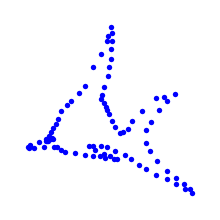

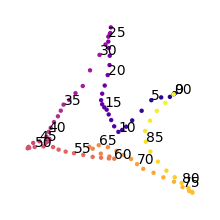

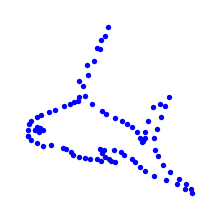

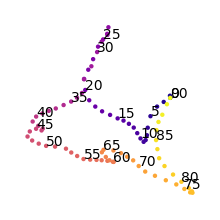

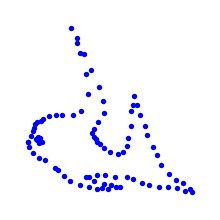

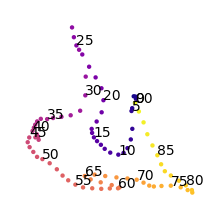

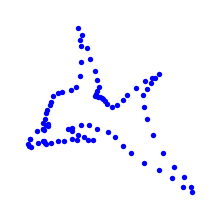

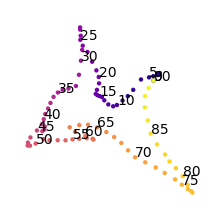

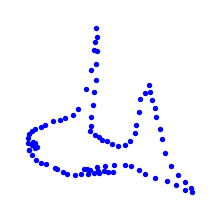

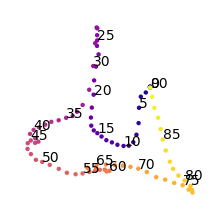

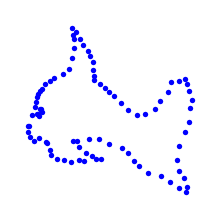

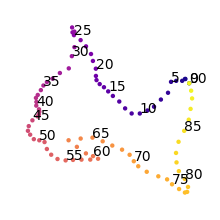

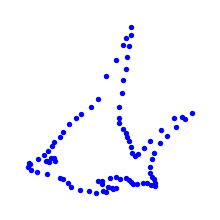

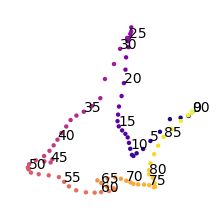

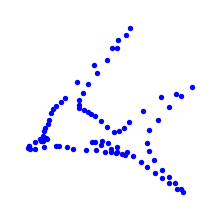

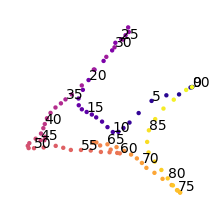

In [30]:
#################
######绘制不同deformation level的图########
#################

x = f0
yt = f1
y_hat = f2
plt.clf()

chocie_list = [55,56,57,58, 59,60,61, 62]

for row in range(8):
    j = chocie_list[row]
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
#         ax = fig.add_subplot(5,10, row*10+ix+1)   
    ax = fig.add_subplot(111)   

    d1=np.asarray((yt[j])).reshape(-1,2)
    ax.scatter(d1[:, 0], d1[:, 1], s=15, linewidths=0, cmap="plasma", marker='o')
#         for iii in range(0, len(d1),3):
#             ax.text(d1[iii,0], d1[iii,1], str(iii))
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)
    fig.savefig('Results/deformation_examples/fig_fish_def4_gt_%d.png' % (j), format='png', transparent=True, dpi=300, pad_inches = 0)
    plt.show()
    
    
    fig = plt.figure(figsize=(2, 2)) #figsize=(5, 5)
    ax = fig.add_subplot(111)
    d=np.asarray((y_hat[j])).reshape(-1,2)                 
    ax.scatter(d[:, 0],d[:, 1],c=range(len(d1)), s=10, linewidths=0, cmap="plasma")
    for iii in range(0, len(d1),5):
        ax.text(d[iii,0], d[iii,1], str(iii),fontsize=10)
    ax.axis('off')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0.1,0.1)
#     fig.savefig('Results/epoch_train2/circle.png')
    fig.savefig('Results/deformation_examples/fig_fish_def4_%d.png' % (j),\
                format='png', transparent=True, dpi=300, pad_inches = 0)

#   fig.savefig('Results/illustrate_fig_fish_%d_epoch_%d.png' % (j, col), dpi=300, bbox_inches='tight')

    plt.show()


